##This code performs training over the Lars dataset using detectron 2 and calculates the Panoptic Quality and mean IoU over the testing dataset.

# Install detectron2

First we have to install all the detectron2 dependencies and import all the modules

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 2.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15292, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 15292 (delta 3), reused 6 (delta 1), pack-reused 15275
Receiving objects: 100% (15292/15292), 6.18 MiB | 18.14 MiB/s, done.
Resolving deltas: 100% (11117/11117), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.1 MB/s eta 0:00:00
  Pre

In [ ]:

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import torch
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from detectron2.projects.deeplab import add_deeplab_config

coco_metadata = MetadataCatalog.get("coco_2017_val_panoptic")
# import Mask2Former project
#from mask2former import add_maskformer2_config

Now a drive is mounted where the dataset will be downloaded

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'UMD_Main/Project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/UMD_Main/Project


#The dataset and its annotations are downloaded

In [ ]:
# download, decompress the data
!wget https://box.vicos.si/lars/lars_v1.0.0_images.zip
!rm -r "./lars_v1.0.0_images"
!unzip lars_v1.0.0_images.zip -d ./lars_v1.0.0_images


--2023-12-14 22:53:52--  https://box.vicos.si/lars/lars_v1.0.0_images.zip
Resolving box.vicos.si (box.vicos.si)... 212.235.189.20
Connecting to box.vicos.si (box.vicos.si)|212.235.189.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1013227874 (966M) [application/zip]
Saving to: ‘lars_v1.0.0_images.zip.2’

lars_v1.0.0_images. 100%[===================>] 966.29M  20.2MB/s    in 55s     

2023-12-14 22:54:48 (17.5 MB/s) - ‘lars_v1.0.0_images.zip.2’ saved [1013227874/1013227874]

Archive:  lars_v1.0.0_images.zip
   creating: ./lars_v1.0.0_images/test/images/
 extracting: ./lars_v1.0.0_images/test/images/orca_flow_14_00150.jpg  
 extracting: ./lars_v1.0.0_images/test/images/yt025_02_00069.jpg  
 extracting: ./lars_v1.0.0_images/test/images/orca_flow_19_00064.jpg  
 extracting: ./lars_v1.0.0_images/test/images/yt007_03_00079.jpg  
 extracting: ./lars_v1.0.0_images/test/images/inhouse_seq_89_00069.jpg  
 extracting: ./lars_v1.0.0_images/test/images/orca_usv_inland_

In [ ]:
!wget https://box.vicos.si/lars/lars_v1.0.0_annotations.zip
!rm -r "./lars_v1.0.0_annotations"
!unzip lars_v1.0.0_annotations -d ./lars_v1.0.0_annotations

Streaming output truncated to the last 5000 lines.
  inflating: ./lars_v1.0.0_annotations/train/panoptic_masks/inhouse_seq_171_00029.png  
  inflating: ./lars_v1.0.0_annotations/train/panoptic_masks/inhouse_seq_33_00249.png  
  inflating: ./lars_v1.0.0_annotations/train/panoptic_masks/mastr_0849_00009.png  
  inflating: ./lars_v1.0.0_annotations/train/panoptic_masks/mastr_0564_00009.png  
  inflating: ./lars_v1.0.0_annotations/train/panoptic_masks/yt099_14_00137.png  
  inflating: ./lars_v1.0.0_annotations/train/panoptic_masks/inhouse_seq_42_00199.png  
  inflating: ./lars_v1.0.0_annotations/train/panoptic_masks/yt056_01_00185.png  
  inflating: ./lars_v1.0.0_annotations/train/panoptic_masks/mastr_0817_00009.png  
  inflating: ./lars_v1.0.0_annotations/train/panoptic_masks/mastr_0254_00009.png  
  inflating: ./lars_v1.0.0_annotations/train/panoptic_masks/davimar_seq_15_00288.png  
  inflating: ./lars_v1.0.0_annotations/train/panoptic_masks/mastr_0749_00009.png  
  inflating: ./lars_v1.

#Another module is installed to create the instance segmentation json for training and validation


In [ ]:
pip install -U sahi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 994.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=2015678e0415b0e83d2a3368ab64eeceee0b1e85ea1c0a683793a91b99a3cc2d
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76


Then the instance json is created from the panoptic annotations

In [ ]:
from sahi.utils.coco import Coco, CocoCategory, CocoImage, CocoAnnotation
from sahi.utils.file import save_json
import os, json, cv2, random
from PIL import Image
coco = Coco()
prefix="./lars_v1.0.0_images/train/images/"
prefix2="./lars_v1.0.0_images/train/"
json_file="./lars_v1.0.0_annotations/train/panoptic_annotations.json"
catList=[]
catDict=[]
with open(json_file) as f:
    imgs_anns = json.load(f)
    imagesList= imgs_anns["annotations"]
    categories= imgs_anns["categories"]

    category_dict = {cat["id"]: cat["name"] for cat in categories if cat["isthing"]}
    for cat_id, cat_name in category_dict.items():
        coco.add_category(CocoCategory(id=cat_id, name=cat_name))
    for image in imagesList:
      width, height = Image.open(prefix+image["file_name"].replace("png","jpg")).size
      coco_image = CocoImage(file_name=image["file_name"].replace("png","jpg"), height=height, width=width,id=image["image_id"])
      segments_list=image["segments_info"]
      for segment in segments_list:
        if segment["category_id"] in category_dict:
          x1, y1, w, h = segment["bbox"]
          x2, y2 = x1 + w, y1 + h
          segmentation = [[x1, y1, x2, y1, x2, y2, x1, y2, x1, y1]]
          coco_image.add_annotation(CocoAnnotation(
              image_id=image["image_id"],
              bbox=[x1, y1, w, h],
              segmentation=segmentation,
              category_id=segment["category_id"],
              category_name=category_dict[segment["category_id"]]
          ))
      coco.add_image(coco_image)
    save_json(data=coco.json, save_path=prefix2+"larsWithCOCO.json")


In [ ]:

from sahi.utils.coco import Coco, CocoCategory, CocoImage, CocoAnnotation
from sahi.utils.file import save_json
import os, json, cv2, random
from PIL import Image
coco = Coco()
prefix="./lars_v1.0.0_images/val/images/"
prefix2="./lars_v1.0.0_images/val/"
json_file="./lars_v1.0.0_annotations/val/panoptic_annotations.json"
catDict=[]
catList=[]
with open(json_file) as f:
    imgs_anns = json.load(f)
    imagesList= imgs_anns["annotations"]
    categories= imgs_anns["categories"]

    category_dict = {cat["id"]: cat["name"] for cat in categories if cat["isthing"]}
    for cat_id, cat_name in category_dict.items():
        coco.add_category(CocoCategory(id=cat_id, name=cat_name))
    for image in imagesList:
      width, height = Image.open(prefix+image["file_name"].replace("png","jpg")).size
      coco_image = CocoImage(file_name=image["file_name"].replace("png","jpg"), height=height, width=width,id=image["image_id"])
      segments_list=image["segments_info"]
      for segment in segments_list:
        if segment["category_id"] in category_dict:
          x1, y1, w, h = segment["bbox"]
          x2, y2 = x1 + w, y1 + h
          segmentation = [[x1, y1, x2, y1, x2, y2, x1, y2, x1, y1]]
          coco_image.add_annotation(CocoAnnotation(
              image_id=image["image_id"],
              bbox=[x1, y1, w, h],
              segmentation=segmentation,
              category_id=segment["category_id"],
              category_name=category_dict[segment["category_id"]]
          ))
      coco.add_image(coco_image)
    save_json(data=coco.json, save_path=prefix2+"larsWithCOCO.json")


#The dataset is registered and the metadata is defined

In [ ]:
name="lars_dataset_train"

In [ ]:
from detectron2.data.datasets import register_coco_panoptic,register_coco_panoptic_separated
import os

from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog
import json


# Path to your JSON file
json_file_path = './lars_v1.0.0_annotations/train/panoptic_annotations.json'

# Read the JSON file
with open(json_file_path) as file:
    data = json.load(file)

categories = data['categories']
thing_classes = []
stuff_classes = []
thing_colors = []
stuff_colors = []

for cat in categories:
    if cat['isthing'] == 1:
        thing_classes.append(cat['name'])
        thing_colors.append(cat['color'])
    else:
        stuff_classes.append(cat['name'])
        stuff_colors.append(cat['color'])

thing_dataset_id_to_contiguous_id = {11: 0, 12: 1, 13: 2, 14: 3, 15: 4, 16: 5, 17: 6, 19: 7}
stuff_dataset_id_to_contiguous_id = {1: 0, 3: 1, 5: 2}



root_dir = './lars_v1.0.0_images/train/'
root_dir2 = './lars_v1.0.0_annotations/train/'
image_root = os.path.join(root_dir, "images")
panoptic_root= os.path.join(root_dir2, "panoptic_masks")
panoptic_json= os.path.join(root_dir2, "panoptic_annotations.json")
semantic_root=os.path.join(root_dir2, "semantic_masks")
instance_json=os.path.join(root_dir, "larsWithCOCO.json")

# Add thing and stuff classes and their colors to the metadata
#MetadataCatalog.get(name).set(thing_classes=thing_classes, stuff_classes=stuff_classes,
#                                      thing_colors=thing_colors, stuff_colors=stuff_colors)

# Add thing and stuff classes and their colors to the metadata
#MetadataCatalog.get(name+"_separated").set(thing_classes=thing_classes, stuff_classes=stuff_classes,
#                                      thing_dataset_id_to_contiguous_id=thing_dataset_id_to_contiguous_id,
#                                      stuff_dataset_id_to_contiguous_id=stuff_dataset_id_to_contiguous_id,
 #                                     thing_colors=thing_colors, stuff_colors=stuff_colors)

#register_coco_panoptic(name, {}, image_root, panoptic_root, panoptic_json,semantic_root)
#register_coco_instances("lars_dataset_val", {}, "./Lars_Dataset/data/train/larsWithCOCO.json", "./Lars_Dataset/val/train/images/")
register_coco_panoptic_separated(name, {}, image_root, panoptic_root, panoptic_json, semantic_root,instance_json)





# Add thing and stuff classes and their colors to the metadata
#MetadataCatalog.get(name).set(thing_classes=thing_classes, stuff_classes=stuff_classes,
#                                      thing_dataset_id_to_contiguous_id=thing_dataset_id_to_contiguous_id,
#                                      stuff_dataset_id_to_contiguous_id=stuff_dataset_id_to_contiguous_id,
#                                      thing_colors=thing_colors, stuff_colors=stuff_colors)

# Add thing and stuff classes and their colors to the metadata
MetadataCatalog.get(name+"_separated").set(thing_classes=thing_classes, stuff_classes=stuff_classes,
                                      thing_dataset_id_to_contiguous_id=thing_dataset_id_to_contiguous_id,
                                      stuff_dataset_id_to_contiguous_id=stuff_dataset_id_to_contiguous_id,
                                      thing_colors=thing_colors, stuff_colors=stuff_colors)

#tings = ["Boat/ship","Row boats","Paddle board","Buoy","Swimmer","Animal","Float","Other"]

#stuffs = ["Static Obstacle", "Water", "Sky"]
#MetadataCatalog.get(name).set(thing_classes=tings, stuff_classes=stuffs)


namespace(name='lars_dataset_train_separated',
          panoptic_root='./lars_v1.0.0_annotations/train/panoptic_masks',
          image_root='./lars_v1.0.0_images/train/images',
          panoptic_json='./lars_v1.0.0_annotations/train/panoptic_annotations.json',
          sem_seg_root='./lars_v1.0.0_annotations/train/semantic_masks',
          json_file='./lars_v1.0.0_images/train/larsWithCOCO.json',
          evaluator_type='coco_panoptic_seg',
          ignore_label=255,
          thing_classes=['Boat/ship',
                         'Row boats',
                         'Paddle board',
                         'Buoy',
                         'Swimmer',
                         'Animal',
                         'Float',
                         'Other'],
          stuff_classes=['Static Obstacle', 'Water', 'Sky'],
          thing_dataset_id_to_contiguous_id={11: 0,
                                             12: 1,
                                             13: 2,
              

In [ ]:
from detectron2.data.datasets import register_coco_instances,register_coco_panoptic_separated
import os

root_dir = './lars_v1.0.0_images/val/'
root_dir2 = './lars_v1.0.0_annotations/val/'
image_root = os.path.join(root_dir, "images")
panoptic_root= os.path.join(root_dir2, "panoptic_masks")
panoptic_json= os.path.join(root_dir2, "panoptic_annotations.json")
semantic_root=os.path.join(root_dir2, "semantic_masks")
instance_json=os.path.join(root_dir, "larsWithCOCO.json")
name2="lars_dataset_val"

# Add thing and stuff classes and their colors to the metadata
MetadataCatalog.get(name2).set(thing_classes=thing_classes, stuff_classes=stuff_classes,
                                     thing_dataset_id_to_contiguous_id=thing_dataset_id_to_contiguous_id,
                                      stuff_dataset_id_to_contiguous_id=stuff_dataset_id_to_contiguous_id,
                                      thing_colors=thing_colors, stuff_colors=stuff_colors)

# Add thing and stuff classes and their colors to the metadata
MetadataCatalog.get(name2+"_separated").set(thing_classes=thing_classes, stuff_classes=stuff_classes,
                                      thing_dataset_id_to_contiguous_id=thing_dataset_id_to_contiguous_id,
                                      stuff_dataset_id_to_contiguous_id=stuff_dataset_id_to_contiguous_id,
                                      thing_colors=thing_colors, stuff_colors=stuff_colors)

#register_coco_instances("lars_dataset_train24", {}, "./Lars_Dataset/masks/train/panoptic_annotations.json", "./Lars_Dataset/data/train/images/")
#register_coco_instances("lars_dataset_val", {}, "./Lars_Dataset/data/train/larsWithCOCO.json", "./Lars_Dataset/val/train/images/")
register_coco_panoptic_separated(name2, {}, image_root, panoptic_root, panoptic_json, semantic_root,
                                 instance_json)


#We visualize the registered data on a sample image with its panoptic annotation

WARNING [12/14 21:26:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/14 21:26:32 d2.data.datasets.coco]: Loaded 2605 images in COCO format from ./lars_v1.0.0_images/train/larsWithCOCO.json
[12/14 21:26:32 d2.data.datasets.coco]: Loaded 2605 images with semantic segmentation from ./lars_v1.0.0_images/train/images


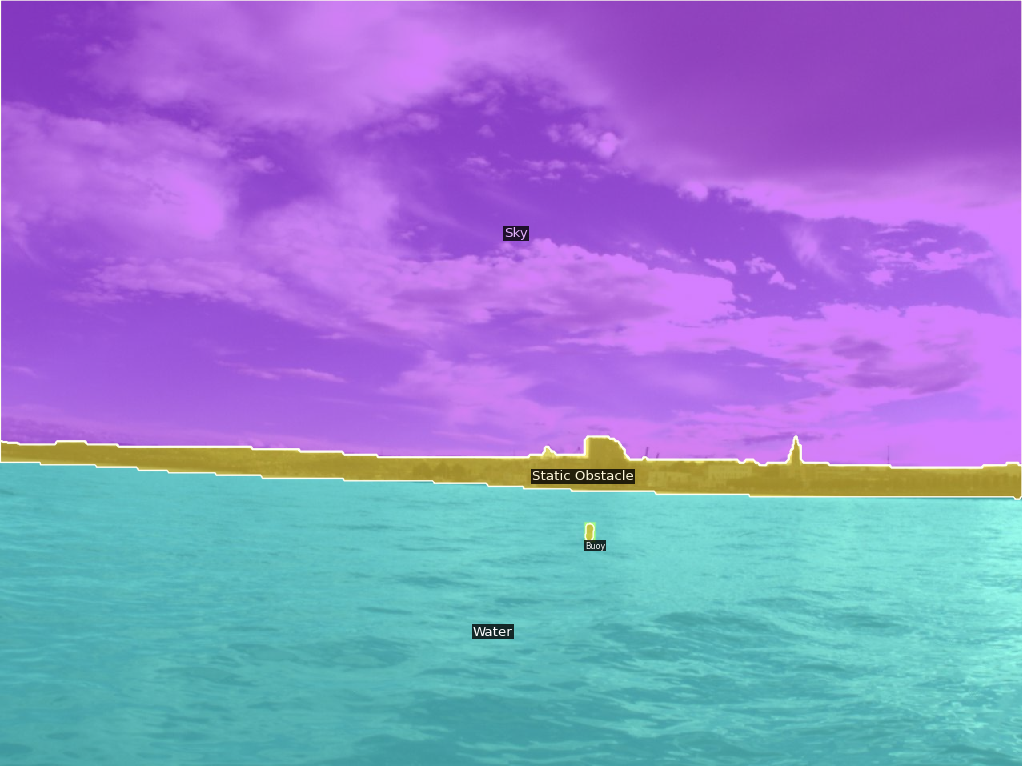

Metadata(name='lars_dataset_train_separated', panoptic_root='./lars_v1.0.0_annotations/train/panoptic_masks', image_root='./lars_v1.0.0_images/train/images', panoptic_json='./lars_v1.0.0_annotations/train/panoptic_annotations.json', sem_seg_root='./lars_v1.0.0_annotations/train/semantic_masks', json_file='./lars_v1.0.0_images/train/larsWithCOCO.json', evaluator_type='coco_panoptic_seg', ignore_label=255, thing_classes=['Boat/ship', 'Row boats', 'Paddle board', 'Buoy', 'Swimmer', 'Animal', 'Float', 'Other'], stuff_classes=['Static Obstacle', 'Water', 'Sky'], thing_dataset_id_to_contiguous_id={11: 0, 12: 1, 13: 2, 14: 3, 15: 4, 16: 5, 17: 6, 19: 7}, stuff_dataset_id_to_contiguous_id={1: 0, 3: 1, 5: 2}, thing_colors=[[255, 39, 43], [255, 39, 43], [255, 39, 43], [255, 39, 43], [255, 39, 43], [255, 39, 43], [255, 39, 43], [255, 39, 43]], stuff_colors=[[255, 212, 25], [70, 245, 255], [170, 0, 255]])


In [ ]:
import random

metadata = MetadataCatalog.get(name+"_separated")
dataset_train = DatasetCatalog.get(name+"_separated")

dataset_entry = dataset_train[1000]
image = cv2.imread(dataset_entry["file_name"])

visualizer = Visualizer(
    image[:, :, ::-1],
    metadata=metadata,
    scale=0.8,
    instance_mode=ColorMode.IMAGE_BW
)

out = visualizer.draw_dataset_dict(dataset_entry)
cv2_imshow(out.get_image()[:, :, ::-1])

print(metadata)

#We train the model with our particular registered training and validation dataset and individual number of classes

In [ ]:
from detectron2.engine import DefaultTrainer
import sys, os, distutils.core
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.DATASETS.TRAIN = (name+"_separated",)
cfg.DATASETS.TEST = (name2+"_separated",)
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300
cfg.SOLVER.STEPS = []
cfg.MODEL.DEVICE='cpu'
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 3


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/14 03:33:48 d2.engine.defaults]: Model:
PanopticFPN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): 

model_final_cafdb1.pkl: 261MB [00:03, 80.9MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
sem_seg_head.predictor.{bias, weight}


[12/14 03:33:52 d2.engine.train_loop]: Starting training from iteration 0
[12/14 03:34:00 d2.engine.hooks]: Total training time: 0:00:07 (0:00:00 on hooks)
[12/14 03:34:00 d2.utils.events]:  iter: 0       lr: N/A  max_mem: 0M


KeyboardInterrupt: ignored

#The trained model is loaded.

In [ ]:
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.DATASETS.TRAIN = (name+"_separated",)
cfg.DATASETS.TEST = (name2+"_separated",)
cfg.MODEL.WEIGHTS ='output/model_final.pth'
cfg.MODEL.DEVICE='cpu'
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 3
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

#Testing our predictions with the ground truth predictions

In [ ]:
from detectron2.data import DatasetCatalog

dataset_dicts = DatasetCatalog.get(name2+"_separated")

WARNING [12/14 22:58:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/14 22:58:32 d2.data.datasets.coco]: Loaded 198 images in COCO format from ./lars_v1.0.0_images/val/larsWithCOCO.json
[12/14 22:58:32 d2.data.datasets.coco]: Loaded 198 images with semantic segmentation from ./lars_v1.0.0_images/val/images


In [ ]:
predictor = DefaultPredictor(cfg)

[12/14 22:58:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output2/model_final.pth ...


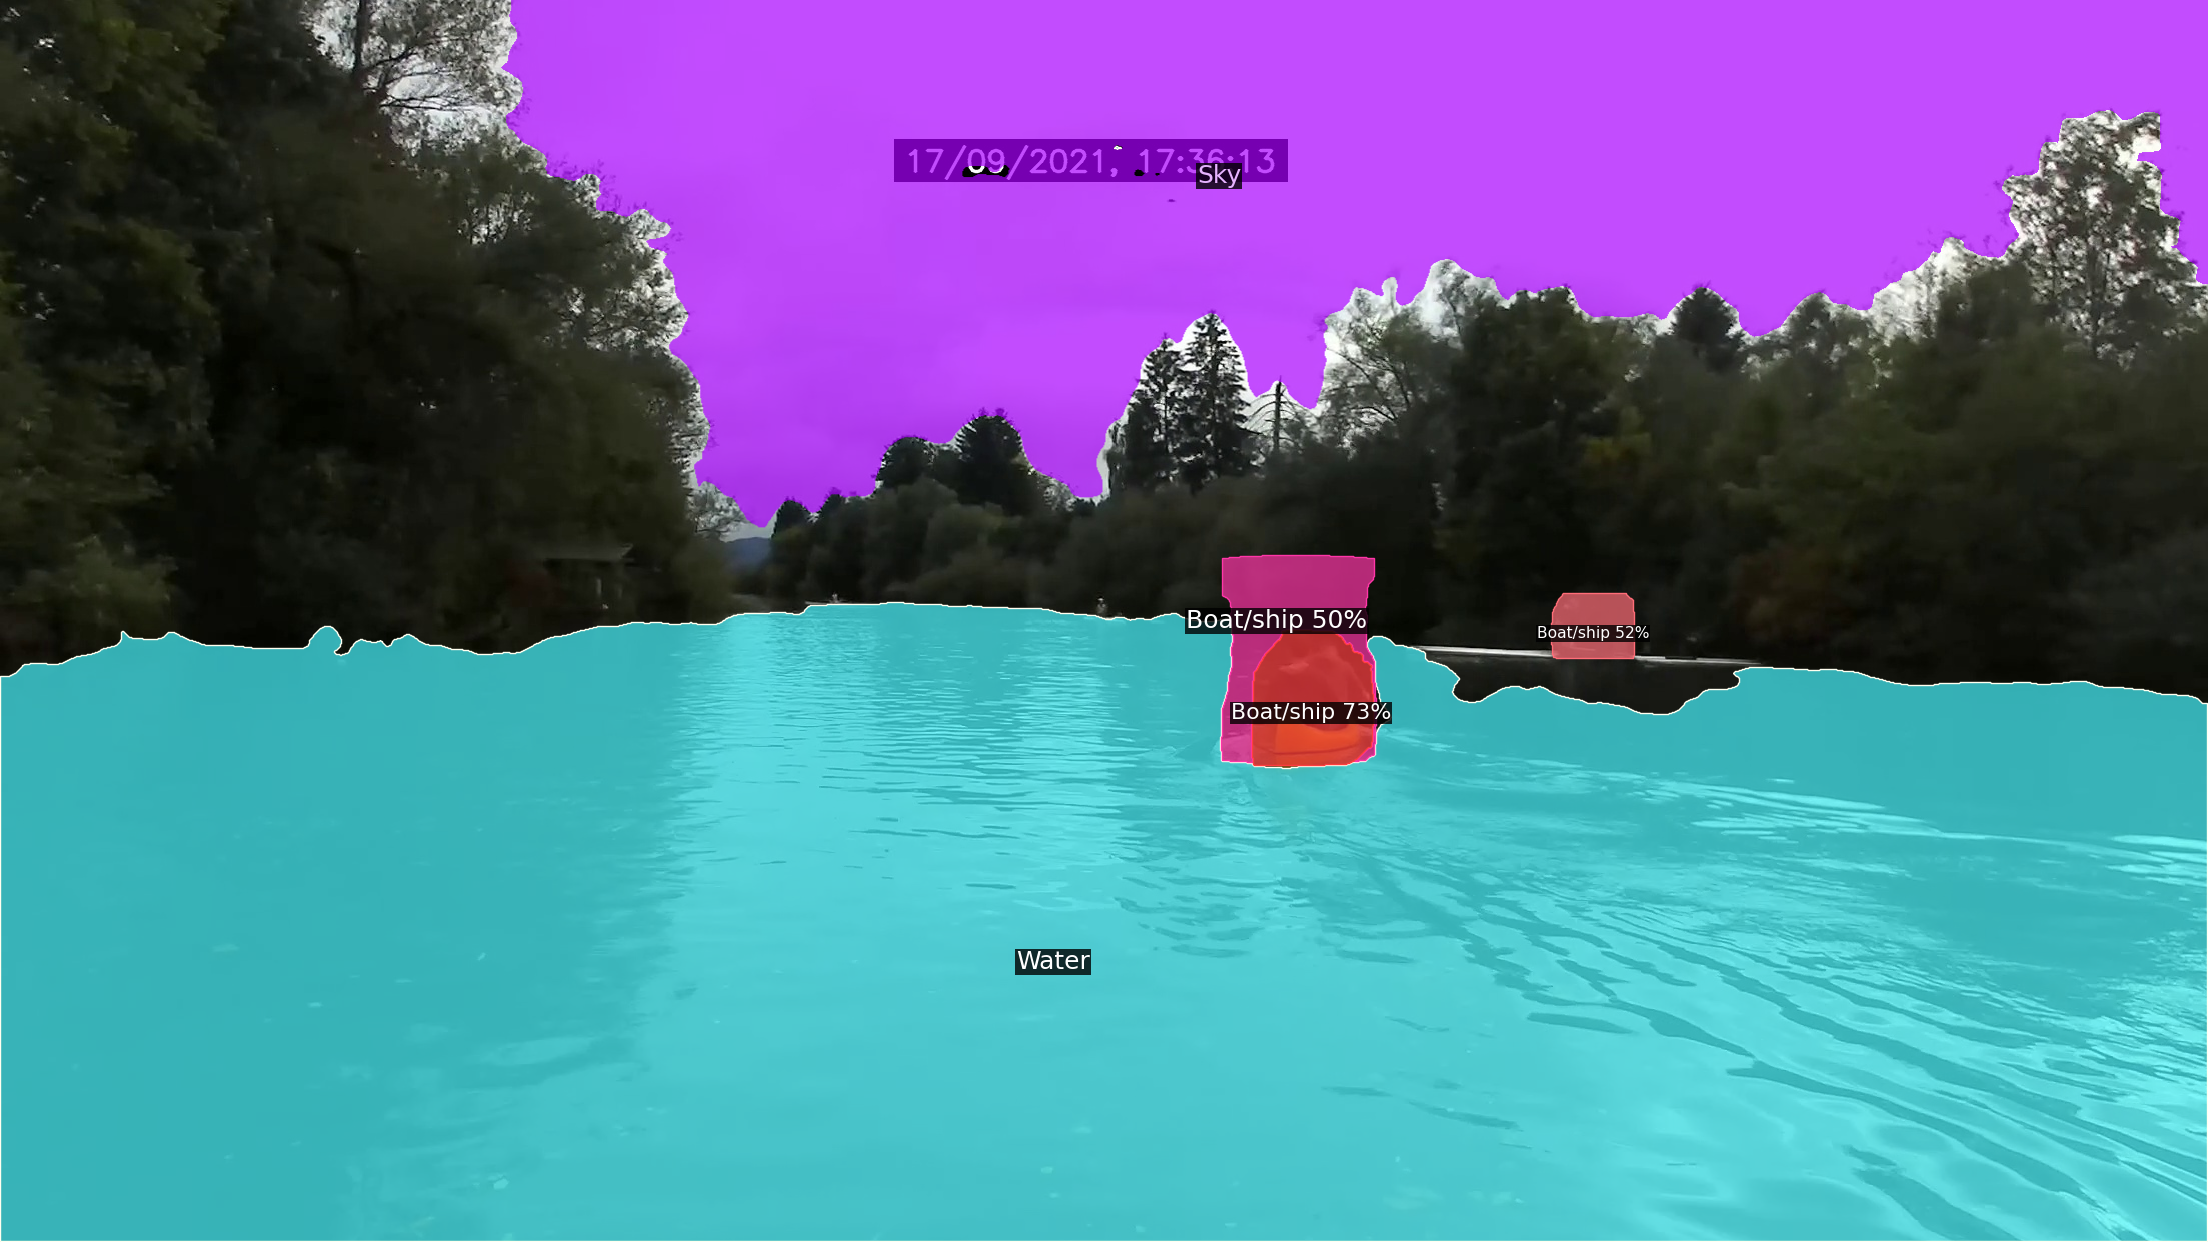

In [ ]:
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from google.colab.patches import cv2_imshow  # Colab-specific function



d=dataset_dicts[27]
img = cv2.imread(d["file_name"])
outputs = predictor(img)
panoptic_seg, segments_info = outputs["panoptic_seg"]
# Visualization for Panoptic Segmentation
v = Visualizer(img[:, :, ::-1],  MetadataCatalog.get(name+"_separated"), scale=1)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])



#Creating the masks to calculate mean IoU and panoptic Quality

In [ ]:
import torch
import numpy as np

# Assume panoptic_seg and segments_info are obtained from the model's output
panoptic_seg, segments_info = outputs["panoptic_seg"]

# Convert panoptic_seg to a NumPy array if it's a torch tensor
if isinstance(panoptic_seg, torch.Tensor):
    panoptic_seg = panoptic_seg.cpu().numpy()

thing_dataset_id_to_contiguous_id = {0: 11, 1: 12, 2: 13, 3: 14, 4: 15, 5: 16, 6: 17, 7: 19}
stuff_dataset_id_to_contiguous_id = {0: 1, 1: 3, 2: 5}

# Initialize lists to store masks and their corresponding classes
masks = []
classes = []
prediction_mask=[]
for segment_info in segments_info:
    # Extract segment ID and class ID
    segment_id = segment_info['id']
    if(segment_info["isthing"]):
      class_id = thing_dataset_id_to_contiguous_id[segment_info['category_id']]
    else:
      class_id = stuff_dataset_id_to_contiguous_id[segment_info['category_id']]
    # Create a binary mask for the current segment
    mask = np.where(panoptic_seg == segment_id, True, False)

    # Store the mask and the class ID
    prediction_mask.append((class_id,mask))
    masks.append(mask)
    classes.append(class_id)

# masks now contains individual binary masks
# classes contains the corresponding class IDs for each mask


In [ ]:
import json
import cv2
import numpy as np
import os

root_dir = './lars_v1.0.0_images/val/'
root_dir2 = './lars_v1.0.0_annotations/val/'
image_root = os.path.join(root_dir, "images")
panoptic_root = os.path.join(root_dir2, "panoptic_masks")
panoptic_json = os.path.join(root_dir2, "panoptic_annotations.json")
semantic_root = os.path.join(root_dir2, "semantic_masks")
instance_json = os.path.join(root_dir, "larsWithCOCO.json")
# Load panoptic annotations JSON
with open(panoptic_json) as f:
    panoptic_data = json.load(f)

# Define a directory where the mask images are stored
mask_dir = panoptic_root


In [ ]:
masks1=[]
import cv2
import os
import numpy as np

def get_ground_truth_masks(panoptic_data, mask_dir, semantic_dir):
    ground_truth_masks = {}

    for img_ann in panoptic_data['annotations']:
        # Load the panoptic mask image
        mask_filename = img_ann['file_name']
        mask_path = os.path.join(mask_dir, mask_filename)
        panoptic_mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        img_masks = []
        instance_masks = panoptic_mask[:, :, 0]
        stuff_masks = panoptic_mask[:, :, 2]
        for seg_info in img_ann['segments_info']:
            category_id = seg_info['category_id']
            segment_id = seg_info['id']

            # Create a binary mask for this segment
            binary_mask = (stuff_masks == category_id)
            img_masks.append((category_id, binary_mask))


        ground_truth_masks[img_ann['image_id']] = img_masks

    return ground_truth_masks


# Process the annotations to get ground truth masks
ground_truth_masks = get_ground_truth_masks(panoptic_data, mask_dir,semantic_root)


In [ ]:
import json

def get_id_from_panoptic_json(i):
    # Load the JSON data
    with open(panoptic_json, 'r') as file:
        data = json.load(file)

    # Assuming the data structure includes a list of annotations
    annotations = data['annotations']

    # Check if i is within the range of annotations
    if i < 0 or i >= len(annotations):
        raise IndexError("Index out of range")

    # Get the 'id' of the i-th annotation
    annotation_id = annotations[i]['image_id']
    return annotation_id

In [ ]:
index = d["image_id"] # Replace with the index you want to access
try:
    annotation_id = get_id_from_panoptic_json(index)
    print(f"The ID of the {index}-th annotation is: {annotation_id}")
except IndexError as e:
    print(e)

The ID of the 28-th annotation is: 2260


#Visualizing the predicted masks with their ids and the ground truth masks

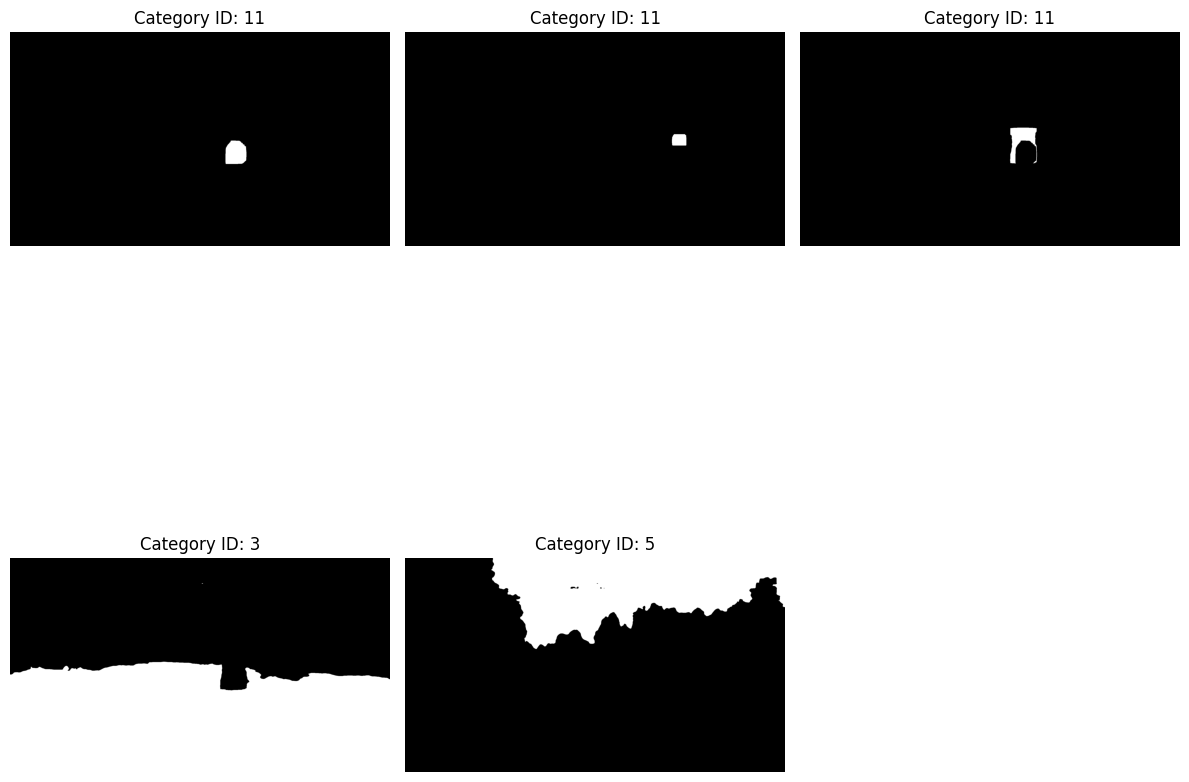

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_masks_with_categories(mask_tuples, cols=3, fig_size=(12, 12)):
    """
    Display a list of masks with category IDs.

    Parameters:
    - mask_tuples: List of tuples, each containing a category ID and a binary numpy array representing a mask.
    - cols: Number of columns in the display grid.
    - fig_size: Size of the figure.
    """
    num_masks = len(mask_tuples)
    rows = num_masks // cols + int(num_masks % cols > 0)

    plt.figure(figsize=fig_size)

    for i, (cat_id, mask) in enumerate(mask_tuples, 1):
        plt.subplot(rows, cols, i)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Category ID: {cat_id}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_masks_with_categories(prediction_mask)


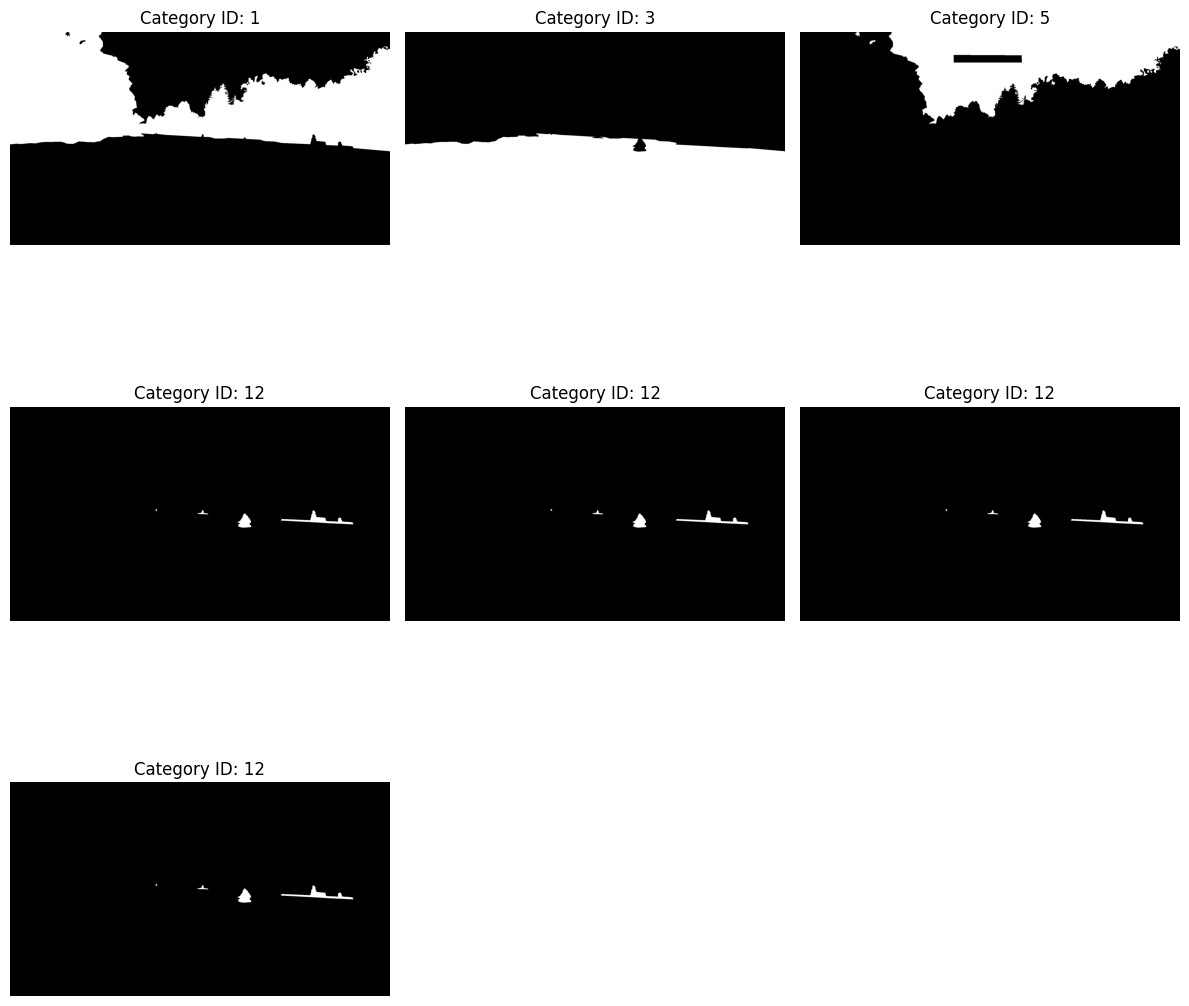

In [ ]:
display_masks_with_categories(ground_truth_masks[2260])


#Calculating mean IoU and Panoptic Quality of a single image

In [ ]:
import numpy as np

def calculate_iou(mask1, mask2):
    """Calculate Intersection over Union of two masks."""
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def mean_iou(predicted, ground_truth):
    """Calculate mean IoU for arrays of (category_id, mask) tuples."""
    category_ids = set([cat_id for cat_id, _ in predicted] + [cat_id for cat_id, _ in ground_truth])
    iou_scores = []

    for cat_id in category_ids:
        pred_mask = next((mask for cid, mask in predicted if cid == cat_id), None)
        gt_mask = next((mask for cid, mask in ground_truth if cid == cat_id), None)

        if pred_mask is not None and gt_mask is not None:
            iou = calculate_iou(pred_mask, gt_mask)
            iou_scores.append(iou)

    return np.mean(iou_scores) if iou_scores else 0

mean_iou_score = mean_iou(prediction_mask, ground_truth_masks[2260])
print("Mean IoU:", mean_iou_score)


Mean IoU: 0.9130195070331878


In [ ]:
import numpy as np

def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    return np.sum(intersection) / np.sum(union)

def calculate_pq(predicted_masks, ground_truth_masks):
    iou_threshold = 0.1
    TP = 0
    FP = 0
    FN = 0
    iou_sum = 0

    matched = set()

    for pred_class,pred_mask in predicted_masks:
        matched_flag = False
        for gt_index, (gt_class,gt_mask) in enumerate(ground_truth_masks):
            if gt_index in matched:
                continue
            if pred_class == gt_class:
                iou = compute_iou(pred_mask, gt_mask)
                if iou > iou_threshold:
                    TP += 1
                    iou_sum += iou
                    matched.add(gt_index)
                    matched_flag = True
                    break

        if not matched_flag:
            FP += 1

    FN = len(ground_truth_masks) - len(matched)

    pq = (iou_sum / TP) * (TP / (TP + 0.5 * FP + 0.5 * FN)) if TP > 0 else 0
    return pq

In [ ]:
pq = calculate_pq(prediction_mask, ground_truth_masks[2260])
print(pq)

0.30433983567772926


#Calculating mean IoU and Panoptic Quality from every single test image

In [ ]:
result1=[]
result2=[]
for i in range(0,len(dataset_dicts)-1):
  d=dataset_dicts[i]
  img = cv2.imread(d["file_name"])
  outputs = predictor(img)
  panoptic_seg, segments_info = outputs["panoptic_seg"]
  # Convert panoptic_seg to a NumPy array if it's a torch tensor
  if isinstance(panoptic_seg, torch.Tensor):
      panoptic_seg = panoptic_seg.cpu().numpy()

  thing_dataset_id_to_contiguous_id = {0: 11, 1: 12, 2: 13, 3: 14, 4: 15, 5: 16, 6: 17, 7: 19}
  stuff_dataset_id_to_contiguous_id = {0: 1, 1: 3, 2: 5}

  # Initialize lists to store masks and their corresponding classes
  masks = []
  classes = []
  prediction_mask=[]

  for segment_info in segments_info:
      # Extract segment ID and class ID
      segment_id = segment_info['id']
      if(segment_info["isthing"]):
        class_id = thing_dataset_id_to_contiguous_id[segment_info['category_id']]
      else:
        class_id = stuff_dataset_id_to_contiguous_id[segment_info['category_id']]
      # Create a binary mask for the current segment
      mask = np.where(panoptic_seg == segment_id, True, False)

      # Store the mask and the class ID
      prediction_mask.append((class_id,mask))
      masks.append(mask)
      classes.append(class_id)
  index = d["image_id"]
  annotation_id = get_id_from_panoptic_json(index)
  try:
    miou=mean_iou(prediction_mask, ground_truth_masks[annotation_id])
    pq=calculate_pq(prediction_mask, ground_truth_masks[annotation_id])
    result1.append(miou)
    result2.append(pq)
    print("iteration: " + str(i+1))
    print("pq is " + str(pq))
    print("miou is " + str(miou))
  except:
    print("Skipped iteration"+ str(i+1))


iteration: 1
pq is 0.20614737528470795
miou is 0.6933944790724564
iteration: 2
pq is 0.18533345432966386
miou is 0.5540131754851275
iteration: 3
pq is 0.2980803407245074
miou is 0.6442245101634935
iteration: 4
pq is 0.14173525915566357
miou is 0.36691290417541095
iteration: 5
pq is 0.5468915063309477
miou is 0.6836143829136846
iteration: 6
pq is 0.1633401277940301
miou is 0.3921151143622115
iteration: 7
pq is 0.10629759374632441
miou is 0.26574398436581104
iteration: 8
pq is 0.2582950955907388
miou is 0.452016417283793
iteration: 9
pq is 0.0900801507549545
miou is 0.2176764888555981
iteration: 10
pq is 0.23388472869799828
miou is 0.29980784787457243
iteration: 11
pq is 0.539155199572277
miou is 0.539155199572277
iteration: 12
pq is 0.1852876628899646
miou is 0.6485068201148761
iteration: 13
pq is 0.3577434733391854
miou is 0.7154869466783708
iteration: 14
pq is 0.33760687208698764
miou is 0.6752137441739753
iteration: 15
pq is 0.33261509453480226
miou is 0.6652301890696045
iteration: 1

In [ ]:
print("Mean IoU")
print(np.mean(result1))
print("PQ")
print(np.mean(result2))

Mean IoU
0.5442661968734394
PQ
0.2671578948270956
